In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True

Mounted at /content/gdrive


In [2]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/nlp_hw')

Задание:

Создайте 1 нейронную сеть, в которой буду сразу все перечисленные слои: 2 CNN слоя с разными параметрами друг за другом, Пулинг слой после каждого CNN слоя, Дропаут в любом месте, GRU и LSTM (причем gru должен быть прямо- а lstm обратнонаправленным, а их последние стейты должны быть сконкатенированы). Обучитесь на тех же данных, что и на семинаре. Посчитайте качество и нарисуйте график. F-мера не должна быть ниже - 0.70

In [3]:
!pip install torch torch-vision

In [4]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [6]:
!pip install pandas scikit-learn matplotlib

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [8]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# данные - статьи из ленты ру, нужно предсказать категорию новости
data = pd.read_csv('lenta_sample.csv')

In [11]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [12]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [13]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [14]:
len(vocab)

670782

In [15]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [16]:
len(filtered_vocab)

55293

In [17]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [18]:
id2word = {i:word for word, i in word2id.items()}

Обертка для данных

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [38]:
MAX_LEN = 100

In [39]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [40]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [41]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [42]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [43]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [44]:
# созданный класс в торче можно использовать просто как слой!

class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channel=32, kernel_size=7, stride=1):
        
        super().__init__()          
        self.KERNEL_SIZE = kernel_size
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channel
        self.STRIDE = stride
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        """
        Хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN
        
        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2
        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2), int((EXP_LEN-MAX_LEN)/2)))
        
        convoluted = self.conv(padded)
        
        return self.act(convoluted)

In [45]:
class Pooling(nn.Module):
    
    def __init__(self, MAX_LEN):
        
        super().__init__()          
        self.KERNEL_SIZE = 2
        self.STRIDE = 2
                
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE, stride=self.STRIDE, padding=0)
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        
        pooled = self.max_pool(embedded)

        MAX_LEN = embedded.size(2) 
        OUT_LEN = pooled.size(2)

        padded = F.pad(pooled, (int((MAX_LEN - OUT_LEN)/2), int((MAX_LEN - OUT_LEN)/2)))

        return self.act(padded)

In [46]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 128
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 150
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        self.RNN_UNITS = 32
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv_1 = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS)
        self.conv_2 = Conv_layer_with_pad(self.OUT_CHANNELS, 16, kernel_size = 2, stride=2)
        #self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE, stride=self.STRIDE) 
        #self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        #self.relu_pool = torch.nn.LeakyReLU()
        self.pool = Pooling(self.EMB_DIM)
        self.gru = nn.GRU(16, self.RNN_UNITS, batch_first=True, num_layers=4)
        self.lstm = nn.LSTM(16, self.RNN_UNITS, batch_first=True, num_layers=2, dropout=0.4)
        self.relu = nn.ReLU()

        self.fc = nn.Linear(self.RNN_UNITS*2, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)

        conv_layer_1 = self.relu(self.pool(self.conv_1(embedded.permute(0, 2, 1))))
        conv_layer_2 = self.relu(self.pool(self.conv_2(conv_layer_1))).permute(0, 2, 1)
        gru = self.gru(conv_layer_2)[0][:, -1]
        lstm = self.lstm(conv_layer_2[:, -1:])[0][:, -1]

        concated = torch.cat((gru, lstm), 1)
        hidden = torch.relu(self.fc(concated))
        outputs=self.act(hidden)

        return outputs

In [62]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 128
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 150
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        self.RNN_UNITS = 32
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv_1 = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS)
        self.conv_2 = Conv_layer_with_pad(self.OUT_CHANNELS, 16, kernel_size = 2, stride=2)

        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE, stride=self.STRIDE) 
        #self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        self.relu_pool = torch.nn.LeakyReLU()
        self.pool = Pooling(self.EMB_DIM)

        self.gru = nn.GRU(16, self.RNN_UNITS, batch_first=True, num_layers=4)
        self.lstm = nn.LSTM(16, self.RNN_UNITS, batch_first=True, num_layers=2, dropout=0.4)
        self.relu = nn.ReLU()

        self.fc = nn.Linear(self.RNN_UNITS*2, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        
        '''pooled = self.max_pool(self.conv_1(embedded.permute(0, 2, 1)))
        MAX_LEN = embedded.size(2) 
        OUT_LEN = pooled.size(2)
        padded = F.pad(pooled, (int((MAX_LEN - OUT_LEN)/2), int((MAX_LEN - OUT_LEN)/2)))
        conv_layer_1 = self.relu(self.relu_pool(padded))'''
        
        conv_layer_1 = self.pool(self.relu(self.conv_1(embedded.permute(0, 2, 1))))
        
        '''pooled = self.max_pool(self.conv_2(conv_layer_1.permute(0, 2, 1)))
        MAX_LEN = conv_layer_1.size(2) 
        OUT_LEN = pooled.size(2)
        padded = F.pad(pooled, (int((MAX_LEN - OUT_LEN)/2), int((MAX_LEN - OUT_LEN)/2)))
        conv_layer_2 = self.relu(self.relu_pool(padded))'''
        
        conv_layer_2 = self.pool(self.relu(self.conv_2(conv_layer_1))).permute(0, 2, 1)

        gru = self.gru(conv_layer_2)[0][:, -1]
        lstm = self.lstm(conv_layer_2[:, -1:])[0][:, -1]

        concated = torch.cat((gru, lstm), 1)
        hidden = torch.relu(self.fc(concated))
        outputs=self.act(hidden)

        return outputs

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

1 вариант

In [48]:
%%time
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.908799614906311; F1 measure: 0.102265625
Loss: 2.905505106449127; F1 measure: 0.10470703125
Loss: 2.90448646068573; F1 measure: 0.10563802083333333
Loss: 2.9042225486040114; F1 measure: 0.106181640625
Loss: 2.9041447386741637; F1 measure: 0.1064140625
Eval -  0.09792983716475097
1
Loss: 2.900038094520569; F1 measure: 0.110625
Loss: 2.9025893712043764; F1 measure: 0.10859375
Loss: 2.9013557291030883; F1 measure: 0.10963541666666667
Loss: 2.902010145783424; F1 measure: 0.109013671875
Loss: 2.902141170024872; F1 measure: 0.108671875
Eval -  0.09779992816091955
2
Loss: 2.900706481933594; F1 measure: 0.1078125
Loss: 2.9034680593013764; F1 measure: 0.10578125
Loss: 2.9025282033284507; F1 measure: 0.10748697916666666
Loss: 2.8713770186901093; F1 measure: 0.1244140625
Loss: 2.789216537475586; F1 measure: 0.1508046875
Eval -  0.3157405411877394
3
Loss: 2.1095170962810514; F1 measure: 0.3321484375
Loss: 2.0535838627815246; F1 measure: 0.35900390625
Loss: 2.004780751069387; F1 measure: 

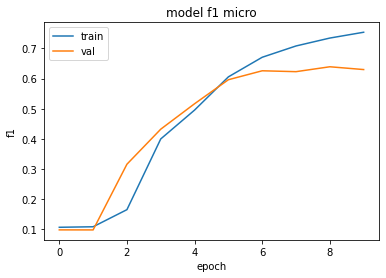

In [49]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2 вариант (тут я немного поменяла порядок слоев)

In [64]:
%%time
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.5634573698043823; F1 measure: 0.2075
Loss: 2.5124964368343354; F1 measure: 0.21181640625
Loss: 2.4880743447939553; F1 measure: 0.21536458333333333
Loss: 2.428839171528816; F1 measure: 0.230712890625
Loss: 2.370196575641632; F1 measure: 0.244765625
Eval -  0.3372503591954023
1
Loss: 1.9789793121814727; F1 measure: 0.3551953125
Loss: 1.9472412246465682; F1 measure: 0.36521484375
Loss: 1.921428142786026; F1 measure: 0.37140625
Loss: 1.9016798695921897; F1 measure: 0.3788671875
Loss: 1.8840366051197053; F1 measure: 0.3863046875
Eval -  0.42779513888888887
2
Loss: 1.7162684071063996; F1 measure: 0.468203125
Loss: 1.7052212786674499; F1 measure: 0.47849609375
Loss: 1.681471767425537; F1 measure: 0.4896484375
Loss: 1.6616485488414765; F1 measure: 0.498798828125
Loss: 1.6391533873081208; F1 measure: 0.5070859375
Eval -  0.5309129549808429
3
Loss: 1.4295249116420745; F1 measure: 0.58140625
Loss: 1.4321346253156662; F1 measure: 0.5826171875
Loss: 1.4210754557450613; F1 measure: 0.58964

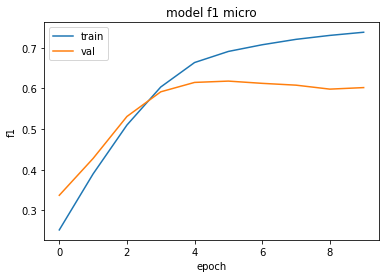

In [65]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Во втором варианте рост пошел быстрее, хотя и спад на валидации тоже побольше